# Tour de France historic analysis

The Tour de France is one of, if not the largest bike races in the world, taking part as one of the three Grand Tours (Giro d'Italia and Vuelta a España being the other two). It is a stage based race, where riders must take part in each stage, and accumulated time is used for the *general classification* (GC), which determines the overall winner.

Alongside the GC, there are 3 other categories in which riders compete:

1. Points classification - typically for sprinters, achieved by winning points at sprints occurring during and at the end of certain stages
2. King/Queen of the Mountains (KoM) - points are attributed to riders in the order they scale classified mountains
3. Best Young Rider - the best placed rider under the age of 25

Competitions are denoted by differently coloured jerseys. While these differ across each Grand Tour, the Tour de France follows the format of yellow jersey for GC, green jersey for points, polkadot jersey for KoM/QoM, and white jersey for best young rider.

Competitions are not distinct from each other, and a single rider can lead any combination of the 4 competitions, however, will only wear one jersey during the race, with the other jerseys 'lent' to the next best rider during stages.

<p align="center">
  <img src="https://library.sportingnews.com/2022-07/tour-de-france-jerseys-072222-getty-ftr.jpg" alt="The four TdF Jerseys"/>
</p>

Teams' different competion goals at the Tour can often define both their tactics and the way in which they prepare team composition. There is, therefore, a huge amount of analysis involved in the tour, and using this dataset, I will try to explore it further.

Firstly, my thanks to user PABLOMONLEON for collating this dataset for use on Kaggle.

In [94]:
import Pkg

# Pkg.add(["DataFrames","Plots","MLJ","CSV","StatsPlots","Dictionaries","Dates"])
using DataFrames
using Plots, StatsPlots, Dictionaries
using MLJ
using CSV
using Dates

# readin
files=readdir(pwd() * "/TdFArchive/")

stages,stagesFull,winner = [CSV.File(pwd()*"/TdFArchive/"*x) |> DataFrame for x in files];

The data collected contains information on the stages themselves, the stage results, and the winner for each edition. First, we can take a look at the conditions regarding the stages over time. For example, how do the distance vary over time?

## Stages through the ages

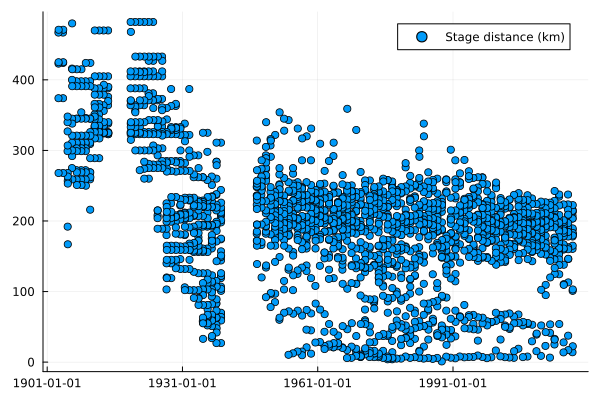

In [2]:
@df stagesFull scatter(
    :Date,
    :Distance,
    label = "Stage distance (km)"
)

First off, we can just how incredibly long the Tour stages used to be compared to the current lengths. All the more incredible realising that until 1937, participants were required to ride on single gear bikes with wooden rims. Following the Second World War and the death of the Tour's progenitor, Henri Desgranges, the Tour settled into a more typical 20-25 stages usually lasting a day. This much is clearly visible from the above plot. If we include information on the types of stages involved:

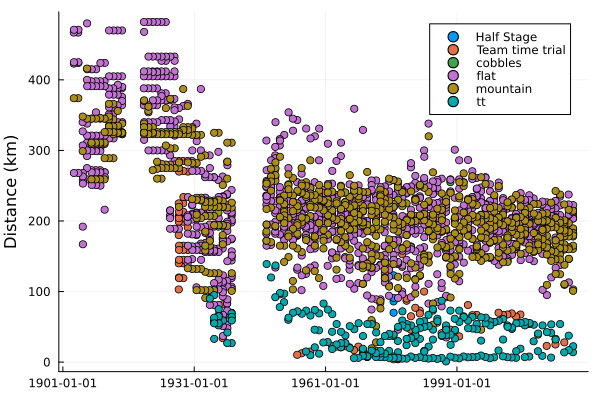

In [176]:
function standardTypes(types)
    stageTypes = Dictionary(["flat","cobbles","mountain","tt"],[("flat stage","intermediate stage","plain stage","transition stage"),("flat cobblestone stage","plain stage with cobblestones"),("high mountain stage","hilly stage","medium mountain stage","mountain stage","stage with mountain","stage with mountain(s)"),("individual time trial","mountain time trial")])    
    vs = fill("",length(types))
    for key in keys(stageTypes)
        inds = findall(Bool.(sum([lowercase.(types) .== x for x in stageTypes[key]])))
        types[inds] .= key
    end
    return types
end
stagesFull.Type = standardTypes(stagesFull.Type);

@df stagesFull scatter(
    :Date,
    :Distance,
    group = :Type,
    ylabel = "Distance (km)"
)

Moving from those early flat or mountain stages, all brutally long, to the introduction of teams (much to Desgranges' chagrin) with team and individual time trials, there is a gradual increase in the variety of stage type seen throughout the tour. It appears, therefore, that the variation in stages observed in the tour hasn't changed too dramatically since the mid to late 1940's. Would it, therefore, be safe to assume that the winners of the Tour have also not varied much in formula since those days?

## Winning qualities

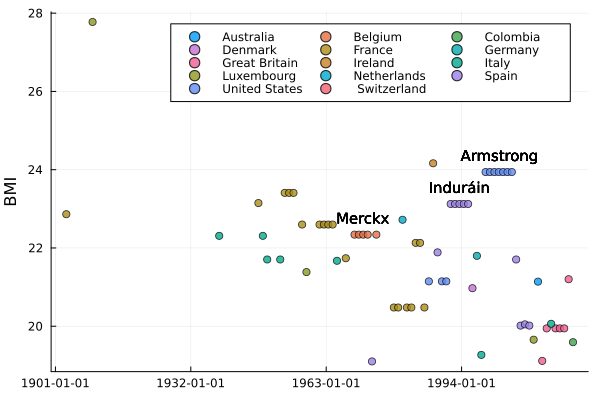

In [177]:
@df winner scatter(
    :start_date,
    :weight./:height.^2,
    group=:nationality,
    legend=:best,
    legendcolumns=3,
    ylabel="BMI",
    markeralpha=0.8
)
bigDogs = Bool.(sum([winner.winner_name .== x for x in ["Lance Armstrong", "Miguel Induráin", "Eddy Merckx"]]))
# findall(winner.winner_name .== "Lance Armstrong")
annotate!(winner.start_date[Int(round(mean(findall(winner.winner_name .== "Lance Armstrong"))))],
    winner.weight[findall(winner.winner_name .== "Lance Armstrong")]./winner.height[findall(winner.winner_name .== "Lance Armstrong")].^2 .+ .2,
    text("Armstrong",10,:bottom))
annotate!(winner.start_date[Int(round(mean(findall(winner.winner_name .== "Miguel Induráin"))))],
    winner.weight[findall(winner.winner_name .== "Miguel Induráin")]./winner.height[findall(winner.winner_name .== "Miguel Induráin")].^2 .+ .2,
    text("Induráin",10,:bottom))
annotate!(winner.start_date[Int(round(mean(findall(winner.winner_name .== "Eddy Merckx"))))],
    winner.weight[findall(winner.winner_name .== "Eddy Merckx")]./winner.height[findall(winner.winner_name .== "Eddy Merckx")].^2 .+ .2,
    text("Merckx",10,:bottom))

With a greater focus on nutrition and modern science applied to training, we see that there is indeed a downward trend in BMI over the years. Some notable exceptions are present, those of Eddy Merckx (1969:1974), Miguel Induráin (1991:1995), and Lance Armstrong (1999:2005). 

Induráin had an extensive legacy on the Tour in being arguably the first time trial specialist to dominate the sport, winning individual time trials by such margins that he could 'get by' in the mountain stages.

Merckx was a phenomenal cyclist who has the joint most stages wins at the Tour, and even won the points jersey in 1969, 1971, 1972, and KoM in 1969 and 1970, alongside winning the yellow jersey in each year.

Armstrong infamously 'won' 7 TdF titles via a sophisticated doping system (albeit during a period tainted by serial performance enhancing scandals, indicative of a peloton-wide epidemic). 

These three cyclists all show quite high BMI values, where Induráin was known for his considerable size for a cyclist, and Armstrong's high BMI may be testament to his doping programme. Overall, however, a downward trend is certainly prevalent. One area that is interesting is speeds at which winners travelled across all competition stages.

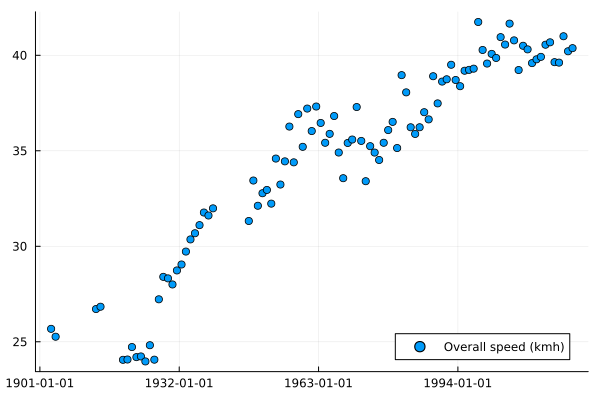

In [5]:
scatter(
    winner.start_date,
    winner.distance./winner.time_overall,
    label="Overall speed (kmh)"
    # legend = nothing
    # legend=:topright
)

We see that a general increase in speed has occurred over time. An interesting area of analysis is looking at general trends of speeds comparing the 'doping era' of the 90s and 2000s.

In [151]:
using Unicode

function sepName(name)
    #=
    Generate Regex expression to search for all names, in any order. Will remove accents, must be accounted for when searching through match

    Args:
        name:   string of full name

    Returns:
        Regex formatted expression of appropriate search term

    Example:
        >>> sepName("Stêphen La Faîre")
        >>> r"^(?=.*\bStephen\b).*^(?=.*\bLa\b).*^(?=.*\bFaire\b).*"
    =#
    name = Unicode.normalize(name,stripmark=true) # remove accents
    inds = [collect(x)[1] for x in findall.(" ", name)] # find spaces
    prepend!(append!(inds,length(name)+1),0)
    ranges = [collect(range(inds[x]+1,inds[x+1]-1)) for x in 1:length(inds)-1] # extract name indices only
    names = [name[x] for x in ranges] # return list of names
    return Regex(join(["^(?=.*\\b" * x * "\\b).*" for x in names]))
end
# function extractWinnerDat(name,year,stage,stageF)

sepName (generic function with 1 method)

In [194]:
# out = DataFrame(edition = Int64[], year = )
# for (win,yr) in zip(winner[:,:winner_name],Dates.year.(Date.(winner.start_date)))
#     indivInfo = stages[(occursin.(sepName(win),Unicode.normalize.(stages.rider,stripmark=true))) .& (yr .== stages.year),:]
#     indivInfo.Stage .= [x[7:end] for x in indivInfo.stage_results_id]
#     stageInfo = stagesFull[(Dates.year.(Date.(stagesFull.Date)) .== yr),:]
#     innerjoin(indivInfo,stageInfo,on=:Stage)
# end

Row,edition,year,stage_results_id,rank,time,rider,age,team,points,elapsed,bib_number,Stage,Date,Distance,Origin,Destination,Type,Winner,Winner_Country
,Int64,Int64,String15,String7,String3?,String,Float64?,String?,Float64?,String3?,Float64?,String15,Date,Float64,String,String31,String31,String,String31?
1,25,1931,stage-1,33,0S,Magne Antonin,27.0,France,missing,12S,33.0,1,1931-06-30,208.0,Paris,Caen,flat,Alfred Haemerlinck,BEL
2,25,1931,stage-2,14,46S,Magne Antonin,27.0,France,2.0,0S,33.0,2,1931-07-01,212.0,Caen,Dinan,flat,Max Bulla,AUT
3,25,1931,stage-3,28,0S,Magne Antonin,27.0,France,missing,29S,33.0,3,1931-07-02,206.0,Dinan,Brest,flat,Fabio Battesini,ITA
4,25,1931,stage-4,30,31S,Magne Antonin,27.0,France,missing,47S,33.0,4,1931-07-03,211.0,Brest,Vannes,flat,André Godinat,FRA
5,25,1931,stage-5,2,0S,Magne Antonin,27.0,France,70.0,49S,33.0,5,1931-07-04,202.0,Vannes,Les Sables d'Olonne,flat,Charles Pélissier,FRA
6,25,1931,stage-6,28,0S,Magne Antonin,27.0,France,missing,20S,33.0,6,1931-07-05,338.0,Les Sables d'Olonne,Bordeaux,flat,Alfred Haemerlinck,BEL
7,25,1931,stage-7,54,47S,Magne Antonin,27.0,France,missing,32S,33.0,7,1931-07-06,180.0,Bordeaux,Bayonne,flat,Gérard Loncke,BEL
8,25,1931,stage-8,25,59S,Magne Antonin,27.0,France,missing,19S,33.0,8,1931-07-07,106.0,Bayonne,Pau,flat,Charles Pélissier,FRA
9,25,1931,stage-9,1,3S,Magne Antonin,27.0,France,100.0,3S,33.0,9,1931-07-08,231.0,Pau,Luchon,mountain,Antonin Magne,FRA


In [214]:
# vcat(eltype.(eachcol(stagesFull)),eltype.(eachcol(stages)))
# names(stages)
DataFrame(names=vcat(propertynames(stagesFull),propertynames(stages)))

Row,names
,Symbol
1,Stage
2,Date
3,Distance
4,Origin
5,Destination
6,Type
7,Winner
8,Winner_Country
9,edition


In [166]:
stagesFull

Row,Stage,Date,Distance,Origin,Destination,Type,Winner,Winner_Country
,String3,Date,Float64,String,String31,String31,String,String31?
1,1,2017-07-01,14.0,Düsseldorf,Düsseldorf,Individual time trial,Geraint Thomas,GBR
2,2,2017-07-02,203.5,Düsseldorf,Liège,Flat stage,Marcel Kittel,GER
3,3,2017-07-03,212.5,Verviers,Longwy,Medium mountain stage,Peter Sagan,SVK
4,4,2017-07-04,207.5,Mondorf-les-Bains,Vittel,Flat stage,Arnaud Démare,FRA
5,5,2017-07-05,160.5,Vittel,La Planche des Belles Filles,Medium mountain stage,Fabio Aru,ITA
6,6,2017-07-06,216.0,Vesoul,Troyes,Flat stage,Marcel Kittel,GER
7,7,2017-07-07,213.5,Troyes,Nuits-Saint-Georges,Flat stage,Marcel Kittel,GER
8,8,2017-07-08,187.5,Dole,Station des Rousses,Medium mountain stage,Lilian Calmejane,FRA
9,9,2017-07-09,181.5,Nantua,Chambéry,High mountain stage,Rigoberto Urán,COL


In [57]:
# [findall.(" ",winner.winner_name[23]),length(winner.winner_name[23])]

inds = [collect(x)[1] for x in findall.(" ", winner.winner_name[23])]

# deleteat!(collect(1:length(winner.winner_name[23])),findall.(" ", winner.winner_name[23])[1])
prepend!(append!(inds,length(winner.winner_name[23])+1),0)
ranges = [collect(range(inds[x]+1,inds[x+1]-1)) for x in 1:length(inds)-1]
# r"+" * [r"(?=.*\b" * winner.winner_name[23][x] * r"\b)" for x in ranges]

# r"(?=.*\b" * winner.winner_name[23][ranges[1]] * r"\b)"
# print(match(r"^" * Regex(join(["(?=.*\b" * winner.winner_name[23][x] * "\b)" for x in ranges])) * r".*$",winner.winner_name[23]))
# r"^" * Regex(join(["(?=.*\b" * winner.winner_name[23][x] * "\b)" for x in ranges])) * r".*$",winner.winner_name[23]
names = [winner.winner_name[23][x] for x in ranges]
occursin(Regex(join(["^(?=.*\\b" * x * "\\b).*" for x in names])),winner.winner_name[21])
# ^(?=.*\bSidney\b)(?=.*\bAlice\b)(?=.*\bPeter\b).*$



false

In [43]:
occursin(Regex("(?=.*\\bMaurice\\b).*(?=.*\\bDe\\b).*(?=.*\\bWaele\\b).*"),winner.winner_name[23])

true

In [41]:
Unicode.normalize.(stages.rider,stripmark=true)

255752-element Vector{String}:
 "Garin Maurice"
 "Pagie Emile"
 "Georget Leon"
 "Augereau Fernand"
 "Fischer Jean"
 "Kerff Marcel"
 "Catteau Alois"
 "Pivin Ernest"
 "Habets Leon"
 "Beaugendre Francois"
 ⋮
 "Konrad Patrick"
 "Keukeleire Jens"
 "Gallopin Tony"
 "Kwiatkowski Michał"
 "Bennett George"
 "Scully Tom"
 "Naesen Oliver"
 "Tratnik Jan"
 "Wurtz Schmidt Mads"